In [ ]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from model_analysis_nets import LeNet, VGG16, ResNet20
from CKA import linear_CKA, kernel_CKA

import numpy as np
import sympy
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

import gudhi as gd
from ripser import Rips


In [15]:
def merge_sublists_with_shared_items(data):
    merged = True
    while merged:
        merged = False
        for i in range(len(data)):
            for j in range(i + 1, len(data)):
                if set(data[i]).intersection(data[j]):
                    data[i] = list(set(data[i]).union(data[j]))
                    del data[j]
                    merged = True
                    break
            if merged:
                break
    return data

def getGradients(modelpth : str = "", model : str = "lenet"):
    if not modelpth:
        return {}
    if model == "lenet":
        model1 = LeNet().to(device)
        dataset_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=trans_mnist)
        test_loader = torch.utils.data.DataLoader(
                        dataset_test, batch_size=32,
                        num_workers=2, pin_memory=True, shuffle=False)
    elif model == "vgg":
        model1 = VGG16().to(device)
        dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
        test_loader = torch.utils.data.DataLoader(
                        dataset_test, batch_size=32,
                        num_workers=2, pin_memory=True, shuffle=False)

    elif model == "resnet":
        model1 = ResNet20().to(device)
        dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
        test_loader = torch.utils.data.DataLoader(
                        dataset_test, batch_size=32,
                        num_workers=2, pin_memory=True, shuffle=False)
                        
    model1.load_state_dict(torch.load(modelpth))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)

    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)
        # print(Y)
        break

    # Forward pass
    outputs = model1(X_test)

    # Compute the loss
    loss = criterion(outputs, Y_test)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Access the gradients
    gradients1 = {}
    for name, param in model1.named_parameters():
        gradients1[name] = param.grad
    return gradients1

def get_total_length(lst):
    total_length = 0

    for item in lst:
        if isinstance(item, list):
            total_length += get_total_length(item)
        else:
            total_length += 1

    return total_length

In [ ]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBAFalse/shard2/pattern06-01--20-25-57/local_attack_save/"
normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBAFalse/shard2/pattern06-01--20-25-57/local_normal_save/"
round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(20,len(client_set_attack),len(client_set_normal))
corr_set = []

if "lenet" in attack_pth:
    model = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    model = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    model = "resnet"
    weightsize = 64
else:
    assert 0==1


In [9]:

for idround, r in enumerate(round_set):
    if idround > 5:
        break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:client_max] + modelpth_dict[f'{r}_attack'][0:client_max]
    # print(len(r_modelpth_set))
    r_corr = np.zeros((client_max * 2, client_max * 2, 1))

    gradientlist = []
    for idx, modelp1 in enumerate(r_modelpth_set):
        gradientlist.append(getGradients(modelp1, model))
    
    for id1, modelp1 in enumerate(gradientlist):
        if id1 >= client_max * 2:
            break
        for id2, modelp2 in enumerate(gradientlist):
            if id2 >= client_max * 2:
                break
            if id2 <= id1:
                continue
            gradients1 = gradientlist[id1]
            gradients2 = gradientlist[id2]
            
            corrlist = []

            # print(gradients1)
            acts1 = gradients1["layer3.0.conv1.weight"]
            acts2 = gradients2["layer3.0.conv1.weight"]
            acts1 = acts1.cpu().reshape((weightsize,-1))
            acts2 = acts2.cpu().reshape((weightsize,-1))
            l = linear_CKA(acts1.T, acts2.T)
            k = kernel_CKA(acts1.T, acts2.T)
            corrlist.append((l+k)/2)

            r_corr[id1][id2] = np.array(corrlist)
    corr_set.append(r_corr)

print(len(corr_set))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

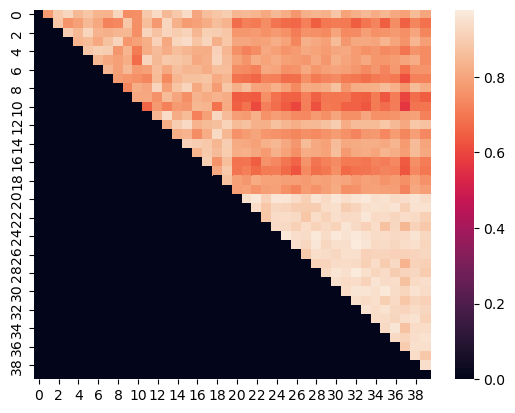

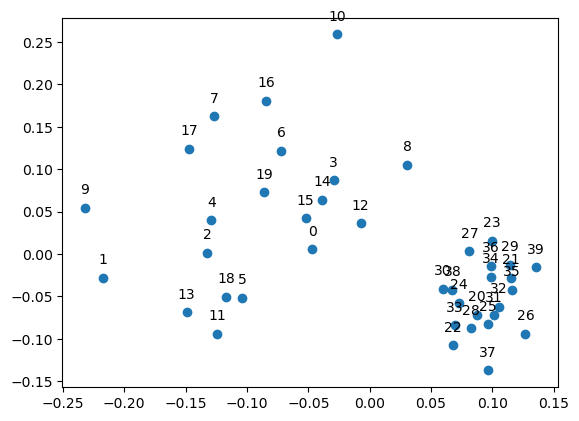

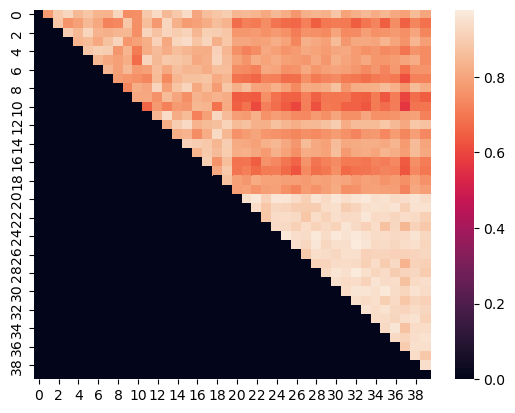

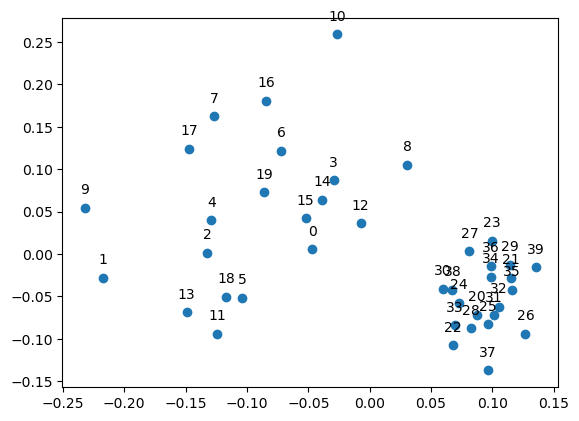

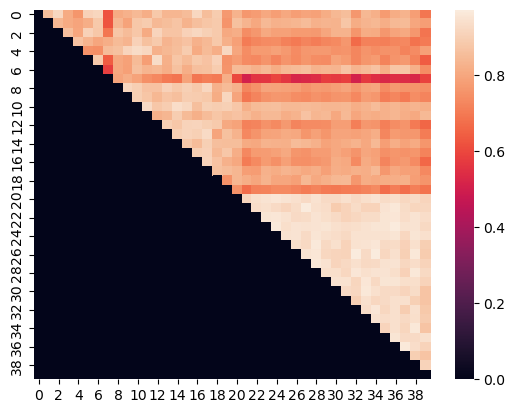

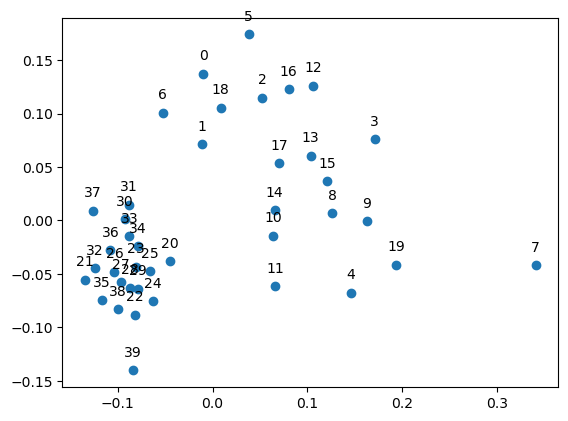

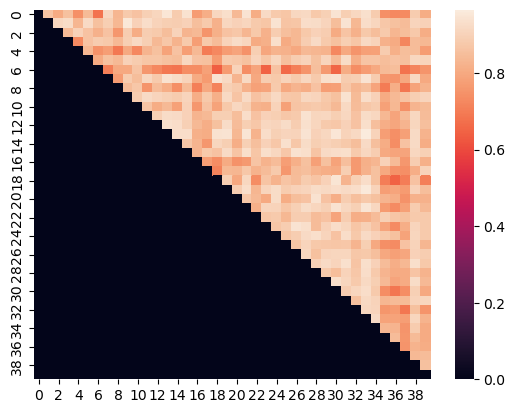

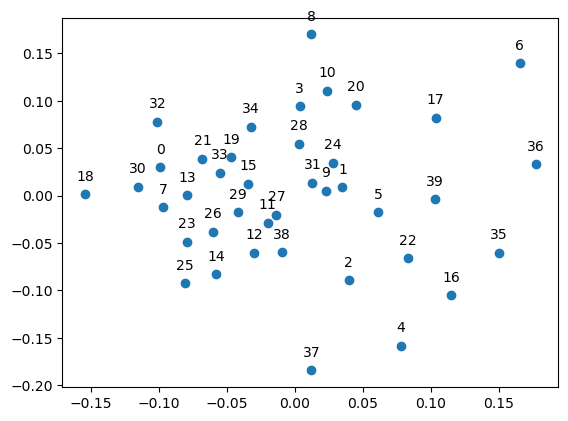

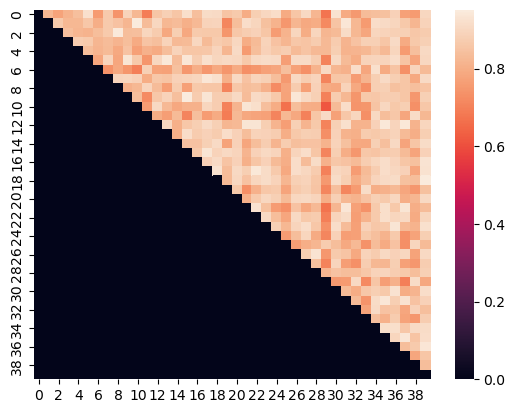

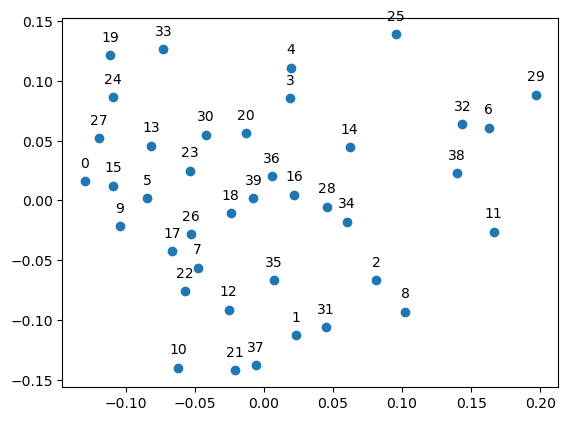

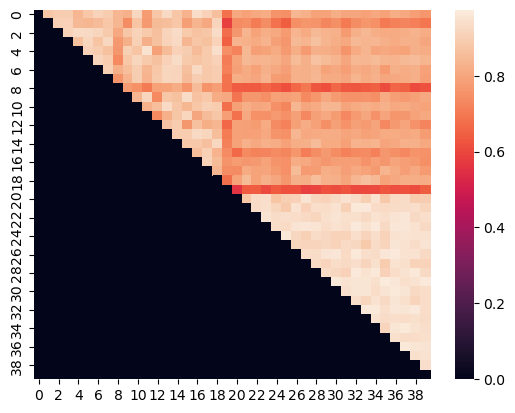

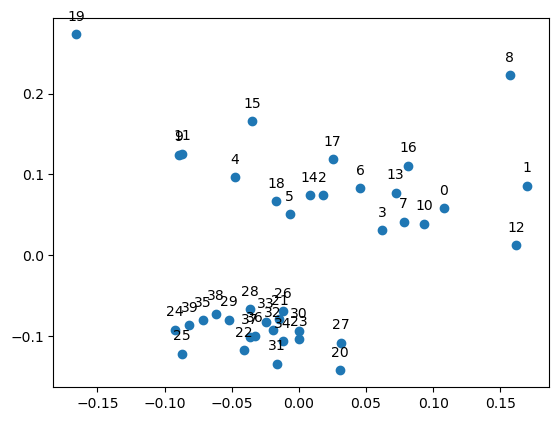

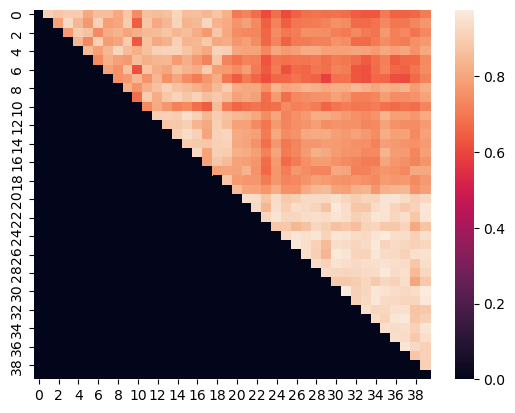

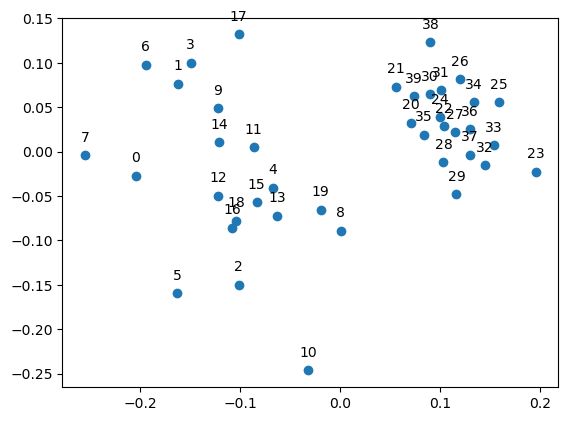

In [10]:

# Your similarity matrix
for corr in corr_set:
    distance_matrix = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    sns.heatmap(corr.reshape(-1, 2 * client_max))
    plt.show()

# Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    results = mds.fit_transform(distance_matrix)

    # Plot the points
    plt.scatter(results[:, 0], results[:, 1])

    for i, points in enumerate(results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.show()


In [16]:
for corr in corr_set:
    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    print(data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    # filtration = simplex_tree.get_filtration()
    # gd.plot_persistence_barcode(persistence=persistence)
    # plt.show()
    
    count = 0
    results = []
    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
        # print(birth_simplices)

        # involved_points = set()

        # for birth_simplex in birth_simplices:
        #     for death_simplex in death_simplices:
        #         if set(birth_simplex).issubset(death_simplex):
        #             involved_points.update(birth_simplex)
        #             involved_points.update(death_simplex)
        
        # involved_points_b = (merge_sublists_with_shared_items(birth_simplices))
        involved_points_d = (merge_sublists_with_shared_items(death_simplices))

        # if len(involved_points_b) >= 0 : 
        #     print('b',count, birth_value, death_value, involved_points_b) 
        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
        count += 1
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    for i in range(0, len(a)):
        if (np.unique(a[i:len(a)]).shape[0] == client_max*2):
            continue
        print("distance =", results[i][0], merge_sublists_with_shared_items(a[i:len(a)]))
        print("score x{}: ".format(get_total_length(merge_sublists_with_shared_items(a[i:len(a)]))/client_max/2),end='')
        for j in merge_sublists_with_shared_items(a[i:len(a)]):
            print([np.mean(np.array(j) >= client_max)], end=' ')
        print()


    group = np.zeros((client_max*2,client_max*2))
    for i in merge_sublists_with_shared_items(a)[0]:
        group[i][i] = 1
    # df=pd.DataFrame(group)
    # plot=seaborn.heatmap(df)
    # plt.show()


    

(40, 40)
d 0 0 0.0 inf []
d 0 1 0.0 0.15349534200599035 [[10, 16]]
d 0 2 0.0 0.11422095445343206 [[1, 9]]
d 0 3 0.0 0.10219608650907985 [[12, 30]]
d 0 4 0.0 0.09900755853026211 [[4, 7]]
d 0 5 0.0 0.0985980407671655 [[16, 17]]
d 0 6 0.0 0.09830197699749599 [[4, 6]]
d 0 7 0.0 0.08980670656908885 [[4, 18]]
d 0 8 0.0 0.08669174191813411 [[2, 15]]
d 0 9 0.0 0.08521809585238316 [[12, 19]]
d 0 10 0.0 0.08119130247927742 [[3, 17]]
d 0 11 0.0 0.07969001617739613 [[2, 11]]
d 0 12 0.0 0.07897219867660854 [[1, 13]]
d 0 13 0.0 0.07833741530838867 [[0, 8]]
d 0 14 0.0 0.07635820045306052 [[2, 5]]
d 0 15 0.0 0.0757751378159669 [[3, 14]]
d 0 16 0.0 0.07032036005359998 [[13, 18]]
d 0 17 0.0 0.0661320777755654 [[0, 12]]
d 0 18 0.0 0.06419392516139155 [[0, 15]]
d 0 19 0.0 0.06351869643387487 [[3, 15]]
d 0 20 0.0 0.060924850941134534 [[11, 13]]
d 0 21 0.0 0.05805146295541719 [[27, 31]]
d 0 22 0.0 0.054120238063481985 [[33, 37]]
d 0 23 0.0 0.049382552874115304 [[26, 32]]
d 0 24 0.0 0.048530578228132115 [[24